In [31]:
train_dir = r"C:\Users\rafci\Desktop\tensorflow-speech-recognition-challenge\train"

In [32]:
import librosa
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from data_preparation import make_spec
torch.random.manual_seed(4)
x = make_spec("yes/bfdb9801_nohash_0.wav", train_dir)+1.3
#torch.random.manual_seed(8)

time_masking = T.TimeMasking(time_mask_param=40)
freq_masking = T.FrequencyMasking(freq_mask_param=40)

time_masked = time_masking(torch.Tensor(x)).numpy()
freq_masked = freq_masking(torch.Tensor(x)).numpy()
# Assuming 'freq_masked' is your final spectrogram after transformations
# spectrogram = freq_masked





c:\Users\rafci\Desktop\transformers\data_preparation.py:25: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],


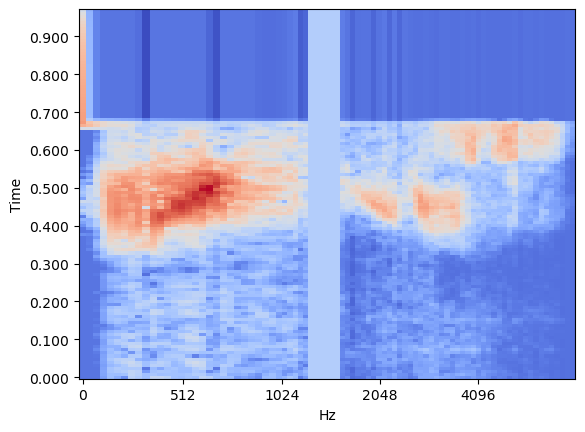

In [33]:
librosa.display.specshow(time_masked,
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)

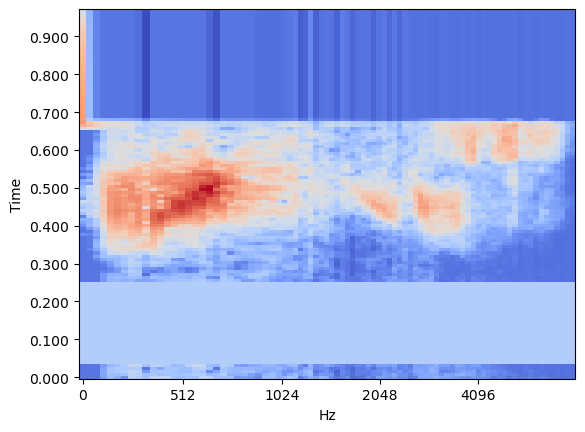

In [34]:
librosa.display.specshow(freq_masked,
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)

In [35]:
import numpy as np
import os

In [36]:
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")



X_val = np.load("data/X_val.npy")
y_val = np.load("data/y_val.npy")

X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2]))



X_val = X_val.reshape((-1, X_val.shape[1], X_val.shape[2]))

classes = os.listdir(train_dir+'/audio/')
NB_CLASSES = len(classes)
classes

def convert_list_dict(lst):
    res_dct = {i: val for i, val in enumerate(lst)}
    return res_dct
         
classes_index = convert_list_dict(classes)
classes_index

{0: 'bed',
 1: 'bird',
 2: 'cat',
 3: 'dog',
 4: 'down',
 5: 'eight',
 6: 'five',
 7: 'four',
 8: 'go',
 9: 'happy',
 10: 'house',
 11: 'left',
 12: 'marvin',
 13: 'nine',
 14: 'no',
 15: 'off',
 16: 'on',
 17: 'one',
 18: 'right',
 19: 'seven',
 20: 'sheila',
 21: 'silence',
 22: 'six',
 23: 'stop',
 24: 'three',
 25: 'tree',
 26: 'two',
 27: 'up',
 28: 'wow',
 29: 'yes',
 30: 'zero'}

In [37]:
import torch.nn.functional as F

import torch

y_train = torch.tensor(y_train).long()
y_val = torch.tensor(y_val).long()
X_train = torch.tensor(X_train)

X_train_masked = freq_masking(X_train)
X_train_masked =time_masking(X_train_masked)

X_val = torch.tensor(X_val)



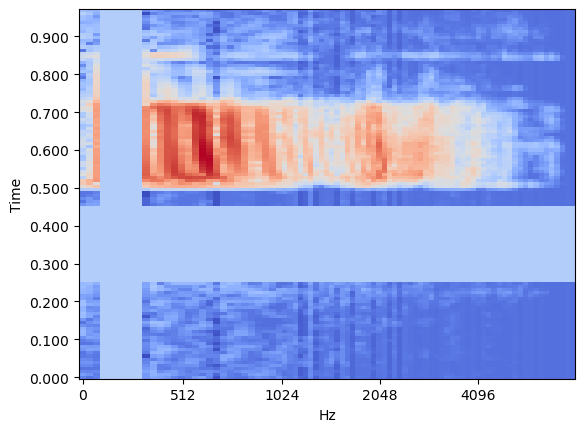

In [38]:
librosa.display.specshow(X_train_masked[0].numpy(),
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)

In [39]:
y_train = F.one_hot(y_train, num_classes=NB_CLASSES)
# y_val = F.one_hot(y_val, num_classes=NB_CLASSES)
print(y_val[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [40]:
from keras.layers import Conv1D, MaxPool1D, Concatenate, BatchNormalization, Activation, Input, Add, \
                         GlobalAveragePooling1D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKeras
from tensorflow.keras.metrics import Recall, Precision
import keras
import time

In [41]:
def f1_score(y_true, y_pred):
    y_pred = y_pred.round().clamp(0, 1)
    y_true = y_true.round().clamp(0, 1)

    true_positives = (y_true * y_pred).sum()
    possible_positives = y_true.sum()
    predicted_positives = y_pred.sum()

    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (possible_positives + 1e-7)

    f1_val = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_val

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import numpy as np
import time

class InceptionModule(nn.Module):
    def __init__(self, in_channels, nb_filters=32, bottleneck_size=32*4, kernel_sizes=[41]):
        super(InceptionModule, self).__init__()
        self.bottleneck_size = bottleneck_size
        
        if bottleneck_size and in_channels > 1:
            self.bottleneck = nn.Conv1d(in_channels, bottleneck_size, kernel_size=1)
        
        self.conv_layers = nn.ModuleList()
        for kernel_size in kernel_sizes:
            self.conv_layers.append(nn.Conv1d(bottleneck_size if bottleneck_size else in_channels,
                                              nb_filters, kernel_size=kernel_size, padding='same'))
        
        self.max_pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.conv_6 = nn.Conv1d(in_channels, nb_filters, kernel_size=1)
        self.batch_norm = nn.BatchNorm1d(nb_filters * len(kernel_sizes) + nb_filters)
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        input_inception = self.bottleneck(x) if hasattr(self, 'bottleneck') else x
        conv_outputs = [conv_layer(input_inception) for conv_layer in self.conv_layers]
        x = self.max_pool(x)
        x = self.conv_6(x)
        conv_outputs.append(x)
        #[print(x.shape) for x in conv_outputs]
        output = torch.cat(conv_outputs, dim=1)
        output = self.batch_norm(output)
        output = F.relu(output)
        return output

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, nb_filters):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, nb_filters, kernel_size=1)
        self.batch_norm = nn.BatchNorm1d(nb_filters)
        
    def forward(self, x):
        shortcut = self.conv(x)
        shortcut = self.batch_norm(shortcut)
        x = x + shortcut
        x = F.relu(x)
        return x

class ClassifierInception(nn.Module):
    def __init__(self, input_shape, nb_classes, nb_filters=32, use_residual=True, use_bottleneck=True,
                 depth=10, kernel_size=41, bottleneck_size=32):
        super(ClassifierInception, self).__init__()
        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size
        self.bottleneck_size = bottleneck_size
        
        self.conv1 = nn.Conv1d(input_shape[0], nb_filters * 4, kernel_size=kernel_size, padding=kernel_size//2, padding_mode='reflect')
        
        inception_modules = [InceptionModule(nb_filters * 4, nb_filters, bottleneck_size, [kernel_size // (2 ** i) for i in range(3)]) 
                             for _ in range(depth)]
        self.inception_modules = nn.Sequential(*inception_modules)
        
        if use_residual:
            self.residual_blocks = nn.ModuleList([ResidualBlock(nb_filters * 4, nb_filters * 4) for _ in range(depth // 3)])
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nb_filters * 4, nb_classes)
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.inception_modules(x)
        
        if self.use_residual:
            for i, block in enumerate(self.residual_blocks):
                if (i + 1) % 3 == 0:
                    x = block(x)
        
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [43]:
INPUT_SHAPE = (85, 122)
print(X_train.shape)
BATCH_SIZE = 64
nb_epochs=10

torch.Size([58284, 122, 85])


In [47]:
torch.random.manual_seed(4)

# Model, criterion, optimizer
model = ClassifierInception(INPUT_SHAPE, NB_CLASSES).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

# Data loaders
train_dataset = TensorDataset(X_train.float().transpose(2, 1).to('cuda'), y_train.float().to('cuda'))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val.float().transpose(2, 1).to('cuda'), y_val.float().to('cuda'))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training loop
for epoch in range(nb_epochs):
    model.train()
    for inputs, labels in train_loader:
        
        inputs = freq_masking(inputs)
        inputs = time_masking(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # _, labels = torch.max(labels, 1)
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{nb_epochs}], Validation Accuracy: {accuracy:.4f}')

print("Training finished.")

Epoch [1/10], Validation Accuracy: 0.4799
Epoch [2/10], Validation Accuracy: 0.7326
Epoch [3/10], Validation Accuracy: 0.7815
Epoch [4/10], Validation Accuracy: 0.8688
Epoch [5/10], Validation Accuracy: 0.8766
Epoch [6/10], Validation Accuracy: 0.8836
Epoch [7/10], Validation Accuracy: 0.8997
Epoch [8/10], Validation Accuracy: 0.9032
Epoch [9/10], Validation Accuracy: 0.9133
Epoch [10/10], Validation Accuracy: 0.9164
Training finished.


In [45]:
# Model, criterion, optimizer
model = ClassifierInception(INPUT_SHAPE, NB_CLASSES).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)

# Data loaders
train_dataset = TensorDataset(X_train.float().transpose(2, 1).to('cuda'), y_train.float().to('cuda'))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val.float().transpose(2, 1).to('cuda'), y_val.float().to('cuda'))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training loop
for epoch in range(nb_epochs):
    model.train()
    for inputs, labels in train_loader:
        
        inputs = freq_masking(inputs)
        inputs = time_masking(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # _, labels = torch.max(labels, 1)
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{nb_epochs}], Validation Accuracy: {accuracy:.4f}')

print("Training finished.")

Epoch [1/10], Validation Accuracy: 0.5284
Epoch [2/10], Validation Accuracy: 0.7345
Epoch [3/10], Validation Accuracy: 0.8304
Epoch [4/10], Validation Accuracy: 0.8465
Epoch [5/10], Validation Accuracy: 0.8764
Epoch [6/10], Validation Accuracy: 0.8503
Epoch [7/10], Validation Accuracy: 0.8677
Epoch [8/10], Validation Accuracy: 0.8919
Epoch [9/10], Validation Accuracy: 0.9073
Epoch [10/10], Validation Accuracy: 0.9107
Training finished.


In [50]:
torch.save(model.state_dict(), 'models/inception_aug.pth')

In [55]:
from Inception import ClassifierInception

model = ClassifierInception(INPUT_SHAPE, NB_CLASSES).to('cuda')
model.load_state_dict(torch.load('models/inception_aug.pth'))
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # _, labels = torch.max(labels, 1)
        
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{nb_epochs}], Validation Accuracy: {accuracy:.4f}')

Epoch [10/10], Validation Accuracy: 0.9164
